Jupyter keyboard shortcuts:
https://blog.ja-ke.tech/2019/01/20/jupyterlab-shortcuts.html

In [17]:
import tensorflow as tf
import pprint
import matplotlib.pyplot as plt
import numpy as np
import efficientnet.efficientnet_builder as net_builder

In [27]:
%%capture
tf.logging.set_verbosity(tf.logging.WARN)
# Set locale for printing (e.g. where to place integer separator ','s).
import locale
locale.setlocale(locale.LC_ALL, '')  # Use '' for auto, or force e.g. to 'en_US.UTF-8'

# Shortcutnet Experiment
Create a network that tries to short-circuit layers in order to reduce 
computation.

## Hypothesis
Can we by, using only earlier layers:
  * detect image classes very low false-positive rates, or
  * detect image class exclusion with very low false-positive rates


Let's imagine that we can do this. When would it be helpful?
For the first case, if we can detect a class with high certainty early in
the network, we can then skip subsequent layers. Let's say we choose the
6th layer of EfficientNet as the shortcut layer. Then we would save computing 
12  following layers, saving over 95% of computation (edit, 95% of parameters 
are in subsequent layers, however, I'm not sure how this relates to ops).
 
For the second case, if we rule out a class with high certainty early in the 
network, we can mark later neurons in the network as being unnecessary. If 
we can mark enough neurons, and if we construct a dependency graph for neurons 
(what neurons are required to calculate later neurons), then maybe we can skip 
whole feature layers from being computed.

## Possible benefit
Count the parameters in EfficientNet layers.

In [13]:
def create_efficientnetb0():
    image_inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    features, endpoints = net_builder.build_model_base(
        image_inputs, model_name='efficientnet-b0', training=True)
    return features, endpoints

In [38]:
def count_elements(tensors):
    """Count individual elements of the given tensors."""
    total = 0
    for t in tensors:
        count = 1
        for dim in t.get_shape():
            count *= dim.value
        total += count
    return total

In [48]:
efficientnet_num_layers = 16
def block_counts():
    bc = list()
    for i in range(efficientnet_num_layers):
        bc.append(count_elements(tf.trainable_variables(
            scope='efficientnet-b0/blocks_{}/'.format(i))))
    return bc

### Parameter totals
Tensorflow trainable parameter counts sum to ~3.5 million. This is much less
than the 5.3 million reported by the EfficientNet paper. I'm not sure why there
is a discrepancy. I assume my counting method is incorrect.

In [55]:
temp_graph = tf.Graph()
with temp_graph.as_default():
    create_efficientnetb0()
    print("Trainables in 'efficientnet-b0' scope:\n\t{:n}".format(
        count_elements(tf.trainable_variables(scope='efficientnet-b0'))))
    print("Trainables in root scope:\n\t{:n}".format(
        count_elements(tf.trainable_variables(scope=None))))
    print("All variables in 'efficientnet-b0' scope:\n\t{:n}".format(
        count_elements(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                         scope='efficientnet-b0'))))
    print("All variables in 'efficientnet-b0' scope:\n\t{:n}".format(
        count_elements(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 
                                         scope=None))))
    
    # Let's confirm that all parameters are covered by the 'efficientnet-b0' 
    # scope.
    not_in_efficientnet_scope = set(
        (v.name for v in tf.trainable_variables(scope='efficientnet-b0') 
                         if not v.name.startswith('efficientnet-b0')))
    assert len(not_in_efficientnet_scope) == 0

Trainables in 'efficientnet-b0' scope:
	3,595,388
Trainables in root scope:
	3,595,388
All variables in 'efficientnet-b0' scope:
	3,634,844
All variables in 'efficientnet-b0' scope:
	3,634,844
[1448, 6004, 10710, 15350, 31290, 37130, 102900, 102900, 126004, 208572, 208572, 262492, 587952, 587952, 587952, 717232]


### Per layer counts
Most trainable parameters exist in the later layers, with the halfway point 
being around the layer 12-13 boundary (50% of trainable parameters are in layer
12 and below).

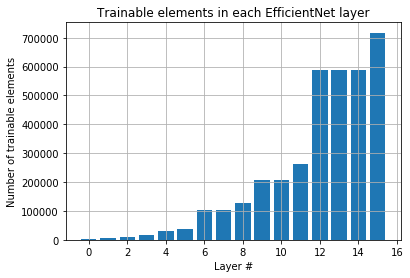

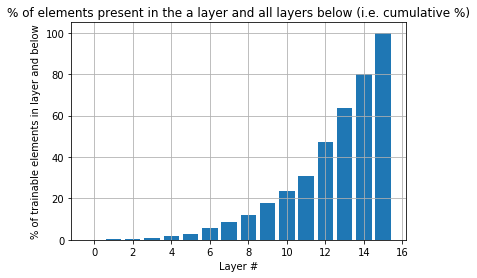

In [72]:
# We still want to be within the above cell's temp_graph scope to save 
# creating another one. However, when I try to do this, block_counts() 
# returns only zeros.
with tf.Graph().as_default():
    create_efficientnetb0()
    # Per-block bar chart.
    y_pos = np.arange(efficientnet_num_layers)
    per_block_params = block_counts()
    plt.bar(y_pos, per_block_params)
    plt.title('Trainable elements in each EfficientNet layer')
    plt.xlabel('Layer #')
    plt.ylabel('Number of trainable elements')
    plt.grid(True) # How to place grids behind bars?
    plt.show()
    
    # Cumulative bar chart.
    # There is probably pyplot inbuild support for cumulative.
    cumulative = per_block_params[:]
    for i in range(1, len(cumulative)):
        cumulative[i] += cumulative[i-1]
    for i in range(len(cumulative)):
        cumulative[i] = 100 * (cumulative[i] / cumulative[-1])
    plt.bar(y_pos, cumulative)
    plt.title('% of elements present in the a layer and all layers below '
              '(i.e. cumulative %)')
    plt.xlabel('Layer #')
    plt.ylabel('% of trainable elements in layer and below')
    plt.grid(True) # How to place grids behind bars?
    plt.show()

Test 1
------
Choose a class ('king penguin', 145).
Can we make a very small network attached to an early layer to detect a king
penguin with a low false-positive rate, say 95%?

Version 1
Arbitrarily testing the 6th layer. The first few layers might be too low in
abstraction to be useful. Attach a low-pass/pooling layer reducing each feature
layer to a single 1D value. Add a fully connected layer (single neuron). The
neuron output is sigmoid. Let's use a standard cross-entropy loss to begin with,
although a loss that penalizes false-positives heavily would be better, I 
imagine. Goal is to see what type of accuracy we can get. 